In [533]:
#import required modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import mlflow
import mlflow.sklearn
from mlflow import log_metric, log_param, log_artifact


#set aesthetics requirements
sns.set(style="white")
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.options.display.float_format = '{:,}'.format
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [534]:
# Reading the csv file and putting it into 'df' object.
leads = pd.read_csv('datasets_78342_179673_olist_marketing_qualified_leads_dataset.csv')
leads.head()

,mql_id,first_contact_date,landing_page_id,origin
0,dac32acd4db4c29c230538b72f8dd87d,2018-02-01,88740e65d5d6b056e0cda098e1ea6313,social
1,8c18d1de7f67e60dbd64e3c07d7e9d5d,2017-10-20,007f9098284a86ee80ddeb25d53e0af8,paid_search
2,b4bc852d233dfefc5131f593b538befa,2018-03-22,a7982125ff7aa3b2054c6e44f9d28522,organic_search
3,6be030b81c75970747525b843c1ef4f8,2018-01-22,d45d558f0daeecf3cccdffe3c59684aa,email
4,5420aad7fec3549a85876ba1c529bd84,2018-02-21,b48ec5f3b04e9068441002a19df93c6c,organic_search


In [535]:
leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
mql_id                8000 non-null object
first_contact_date    8000 non-null object
landing_page_id       8000 non-null object
origin                7940 non-null object
dtypes: object(4)
memory usage: 250.1+ KB


In [536]:
leads.describe(include="all")

,mql_id,first_contact_date,landing_page_id,origin
count,8000,8000,8000,7940
unique,8000,336,495,10
top,524e7d08e755cc664226b3d4b8660cd7,2018-05-02,b76ef37428e6799c421989521c0e5077,organic_search
freq,1,93,912,2296


In [537]:
leads.origin.value_counts()

organic_search       2296
paid_search          1586
social               1350
unknown              1099
direct_traffic        499
email                 493
referral              284
other                 150
display               118
other_publicities      65
Name: origin, dtype: int64

In [538]:
leads['origin'] = leads['origin'].fillna('unknown')

In [539]:
leads.isnull().sum(axis=0)

mql_id                0
first_contact_date    0
landing_page_id       0
origin                0
dtype: int64

In [540]:
leads.describe(include="all")

,mql_id,first_contact_date,landing_page_id,origin
count,8000,8000,8000,8000
unique,8000,336,495,10
top,524e7d08e755cc664226b3d4b8660cd7,2018-05-02,b76ef37428e6799c421989521c0e5077,organic_search
freq,1,93,912,2296


In [541]:
leads["first_contact_date"] = leads["first_contact_date"].astype("datetime64")

In [542]:
leads['first_contact_date'] = leads['first_contact_date'].dt.to_period('M')
leads.head()

,mql_id,first_contact_date,landing_page_id,origin
0,dac32acd4db4c29c230538b72f8dd87d,2018-02,88740e65d5d6b056e0cda098e1ea6313,social
1,8c18d1de7f67e60dbd64e3c07d7e9d5d,2017-10,007f9098284a86ee80ddeb25d53e0af8,paid_search
2,b4bc852d233dfefc5131f593b538befa,2018-03,a7982125ff7aa3b2054c6e44f9d28522,organic_search
3,6be030b81c75970747525b843c1ef4f8,2018-01,d45d558f0daeecf3cccdffe3c59684aa,email
4,5420aad7fec3549a85876ba1c529bd84,2018-02,b48ec5f3b04e9068441002a19df93c6c,organic_search


In [543]:
closed = pd.read_csv('datasets_78342_179673_olist_closed_deals_dataset.csv')
closed.head()

,mql_id,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue
0,5420aad7fec3549a85876ba1c529bd84,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,NaN,NaN,NaN,reseller,nan,0.0
1,a555fb36b9368110ede0f043dfc3b9a0,bbb7d7893a450660432ea6652310ebb7,09285259593c61296eef10c734121d5b,d3d1e91a157ea7f90548eef82f1955e3,2018-05-08 20:17:59,car_accessories,industry,eagle,NaN,NaN,NaN,reseller,nan,0.0
2,327174d3648a2d047e8940d7d15204ca,612170e34b97004b3ba37eae81836b4c,b90f87164b5f8c2cfa5c8572834dbe3f,6565aa9ce3178a5caf6171827af3a9ba,2018-06-05 17:27:23,home_appliances,online_big,cat,NaN,NaN,NaN,reseller,nan,0.0
3,f5fee8f7da74f4887f5bcae2bafb6dd6,21e1781e36faf92725dde4730a88ca0f,56bf83c4bb35763a51c2baab501b4c67,d3d1e91a157ea7f90548eef82f1955e3,2018-01-17 13:51:03,food_drink,online_small,NaN,NaN,NaN,NaN,reseller,nan,0.0
4,ffe640179b554e295c167a2f6be528e0,ed8cb7b190ceb6067227478e48cf8dde,4b339f9567d060bcea4f5136b9f5949e,d3d1e91a157ea7f90548eef82f1955e3,2018-07-03 20:17:45,home_appliances,industry,wolf,NaN,NaN,NaN,manufacturer,nan,0.0


In [544]:
closed.describe(include="all")

,mql_id,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue
count,842,842,842,842,842,841,836,665,63,64,66,832,69.0,842.0
unique,842,842,32,22,824,33,8,9,2,2,6,3,nan,nan
top,3cab34e6c6a51d1f2ca8e76908c62368,f1340f6d3347d9fae747fc3d236a2e41,4b339f9567d060bcea4f5136b9f5949e,4ef15afb4b2723d8f3d81e51ec7afefe,2018-05-04 03:00:00,home_decor,online_medium,cat,True,True,5-20,reseller,nan,nan
freq,1,1,140,133,6,105,332,407,58,54,22,587,nan,nan
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,233.02898550724638,"73,377.67933491686"
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,352.38055844642514,"1,744,799.1768914168"
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0,0.0
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,0.0
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300.0,0.0


In [545]:
closed = closed[['mql_id', 'seller_id']]
closed.head()

,mql_id,seller_id
0,5420aad7fec3549a85876ba1c529bd84,2c43fb513632d29b3b58df74816f1b06
1,a555fb36b9368110ede0f043dfc3b9a0,bbb7d7893a450660432ea6652310ebb7
2,327174d3648a2d047e8940d7d15204ca,612170e34b97004b3ba37eae81836b4c
3,f5fee8f7da74f4887f5bcae2bafb6dd6,21e1781e36faf92725dde4730a88ca0f
4,ffe640179b554e295c167a2f6be528e0,ed8cb7b190ceb6067227478e48cf8dde


In [546]:
data = pd.merge(leads,
                  closed,
                  how='left',
                  on='mql_id')
data.head()

,mql_id,first_contact_date,landing_page_id,origin,seller_id
0,dac32acd4db4c29c230538b72f8dd87d,2018-02,88740e65d5d6b056e0cda098e1ea6313,social,NaN
1,8c18d1de7f67e60dbd64e3c07d7e9d5d,2017-10,007f9098284a86ee80ddeb25d53e0af8,paid_search,NaN
2,b4bc852d233dfefc5131f593b538befa,2018-03,a7982125ff7aa3b2054c6e44f9d28522,organic_search,NaN
3,6be030b81c75970747525b843c1ef4f8,2018-01,d45d558f0daeecf3cccdffe3c59684aa,email,NaN
4,5420aad7fec3549a85876ba1c529bd84,2018-02,b48ec5f3b04e9068441002a19df93c6c,organic_search,2c43fb513632d29b3b58df74816f1b06


In [547]:
data['seller_id'] = data['seller_id'].fillna(0)
data['seller_id'] = data['seller_id'].apply(lambda x: 1 if x else 0)
data.head()

,mql_id,first_contact_date,landing_page_id,origin,seller_id
0,dac32acd4db4c29c230538b72f8dd87d,2018-02,88740e65d5d6b056e0cda098e1ea6313,social,0
1,8c18d1de7f67e60dbd64e3c07d7e9d5d,2017-10,007f9098284a86ee80ddeb25d53e0af8,paid_search,0
2,b4bc852d233dfefc5131f593b538befa,2018-03,a7982125ff7aa3b2054c6e44f9d28522,organic_search,0
3,6be030b81c75970747525b843c1ef4f8,2018-01,d45d558f0daeecf3cccdffe3c59684aa,email,0
4,5420aad7fec3549a85876ba1c529bd84,2018-02,b48ec5f3b04e9068441002a19df93c6c,organic_search,1


In [548]:
monthly_conversion = data.groupby(by='first_contact_date')['seller_id'].agg(['count', 'sum'])
monthly_conversion['conversion_rate(%)'] = ((monthly_conversion['sum'] / monthly_conversion['count']) * 100).round(1)
monthly_conversion

,count,sum,conversion_rate(%)
first_contact_date,,,
2017-06,4,0,0.0
2017-07,239,2,0.8
2017-08,386,9,2.3
2017-09,312,7,2.2
2017-10,416,14,3.4
2017-11,445,18,4.0
2017-12,200,11,5.5
2018-01,1141,152,13.3
2018-02,1028,149,14.5


Text(0.5, 1.0, 'Conversion Rate (Jun 2017 - May 2018)')

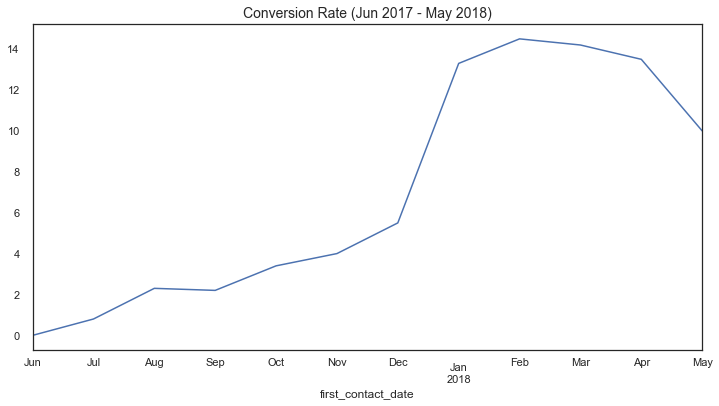

In [549]:
# Plot the monthly conversion rate
monthly_conversion['conversion_rate(%)'].plot.line(figsize=(12, 6))
plt.title('Conversion Rate (Jun 2017 - May 2018)', fontsize=14)

### There is no seasonality is converion. Company is improving lead generation and conversion over time. Hence contact date is not useful to predict if lead will get converted. 

In [550]:
data.drop('first_contact_date', axis=1, inplace = True)
data.head()

,mql_id,landing_page_id,origin,seller_id
0,dac32acd4db4c29c230538b72f8dd87d,88740e65d5d6b056e0cda098e1ea6313,social,0
1,8c18d1de7f67e60dbd64e3c07d7e9d5d,007f9098284a86ee80ddeb25d53e0af8,paid_search,0
2,b4bc852d233dfefc5131f593b538befa,a7982125ff7aa3b2054c6e44f9d28522,organic_search,0
3,6be030b81c75970747525b843c1ef4f8,d45d558f0daeecf3cccdffe3c59684aa,email,0
4,5420aad7fec3549a85876ba1c529bd84,b48ec5f3b04e9068441002a19df93c6c,organic_search,1


In [551]:
dist = data.groupby(['landing_page_id', 'origin'],  as_index=False).mql_id.count()
dist.to_csv (r'train_distribution.csv', index = False, header=True)

In [559]:
landing_page_id_list = pd.DataFrame(data.landing_page_id.unique())
landing_page_id_list.to_csv (r'landing_page_id_list.csv', index = False, header=True)

In [561]:
origin_list = pd.DataFrame(data.origin.unique())
origin_list.to_csv (r'origin_list.csv', index = False, header=True)

### MLflow setup

In [492]:
with mlflow.start_run():
    encoder_landing_page_id = preprocessing.LabelEncoder()
    encoder_landing_page_id.fit(data['landing_page_id'])
    data['landing_page_id'] = encoder_landing_page_id.transform(data['landing_page_id'])

    encoder_origin = preprocessing.LabelEncoder()
    encoder_origin.fit(data['origin'])
    data['origin'] = encoder_origin.transform(data['origin'])
    
    # Log encoder model to MLflow    
    mlflow.set_tag('Stage', 'Data preporcessing') 
    mlflow.sklearn.log_model(encoder_landing_page_id, "encoder_landing_page_id")
    mlflow.sklearn.log_model(encoder_origin, "encoder_origin")

data.head()

,mql_id,landing_page_id,origin,seller_id
0,dac32acd4db4c29c230538b72f8dd87d,262,8,0
1,8c18d1de7f67e60dbd64e3c07d7e9d5d,0,6,0
2,b4bc852d233dfefc5131f593b538befa,321,3,0
3,6be030b81c75970747525b843c1ef4f8,407,2,0
4,5420aad7fec3549a85876ba1c529bd84,345,3,1


In [521]:
encoder_origin.transform(pd.DataFrame(['social']))

array([8])

In [493]:
X = data[['landing_page_id', 'origin']]
y = data['seller_id']

In [494]:
X.head()

,landing_page_id,origin
0,262,8
1,0,6
2,321,3
3,407,2
4,345,3


In [495]:
y.head()

0    0
1    0
2    0
3    0
4    1
Name: seller_id, dtype: int64

### 80% train, 20% test

In [496]:
# Splitting the data into train and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

In [497]:
print(X_train.info())
X_train.to_csv (r'X_train.csv', index = False, header=True)
y_train.to_csv (r'y_train.csv', index = False, header=True)
X_test.to_csv (r'X_test.csv', index = False, header=True)
y_test.to_csv (r'y_test.csv', index = False, header=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5600 entries, 4641 to 4959
Data columns (total 2 columns):
landing_page_id    5600 non-null int64
origin             5600 non-null int64
dtypes: int64(2)
memory usage: 131.2 KB
None


In [498]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')
print(X_train.info())
print(y_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5600 entries, 0 to 5599
Data columns (total 2 columns):
landing_page_id    5600 non-null int64
origin             5600 non-null int64
dtypes: int64(2)
memory usage: 87.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5600 entries, 0 to 5599
Data columns (total 1 columns):
seller_id    5600 non-null int64
dtypes: int64(1)
memory usage: 43.8 KB
None


In [499]:
#print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
#print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0))) 
  
sm = SMOTE(random_state = 2) 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
  


In [500]:
# Running the random forest with default parameters.
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train_res,y_train_res)

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [501]:
# Making predictions
predictions = rfc.predict(X_train_res)

# Let's check the report of our default model
print(classification_report(y_train_res,predictions))

# Making predictions
predictions = rfc.predict(X_test)

# Let's check the report of our default model
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.82      0.67      0.74      5003
           1       0.72      0.85      0.78      5003

    accuracy                           0.76     10006
   macro avg       0.77      0.76      0.76     10006
weighted avg       0.77      0.76      0.76     10006

              precision    recall  f1-score   support

           0       0.94      0.64      0.76      2155
           1       0.17      0.67      0.27       245

    accuracy                           0.64      2400
   macro avg       0.56      0.65      0.52      2400
weighted avg       0.86      0.64      0.71      2400



In [502]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'min_samples_split': range(2, 10, 2),
    'n_estimators': [10, 50, 100]
}
# Create a based model
rf = RandomForestClassifier(random_state=42)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, scoring="recall",
                          cv = 3, n_jobs = -1,verbose = 1)

In [503]:
# Fit the grid search to the data
grid_search.fit(X_train_res, y_train_res)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    3.9s finished
//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [504]:
# printing the optimal accuracy score and hyperparameters
print('We can get recall of',grid_search.best_score_,'using',grid_search.best_params_)

with mlflow.start_run():
    mlflow.set_tag('Stage', 'Hyperparameter Tuning') 
    mlflow.log_params(grid_search.best_params_)
    mlflow.log_metric("recall", grid_search.best_score_)

We can get recall of 0.808513477160683 using {'min_samples_split': 2, 'n_estimators': 50}


In [505]:
rfc = RandomForestClassifier(min_samples_split=2, n_estimators=50, random_state=42)
# fit
rfc.fit(X_train_res,y_train_res)

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [506]:
#validation

# Making predictions
predictions = rfc.predict(X_test)

# Let's check the report of our default model
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.94      0.63      0.76      2155
           1       0.17      0.66      0.27       245

    accuracy                           0.64      2400
   macro avg       0.56      0.65      0.51      2400
weighted avg       0.86      0.64      0.71      2400



In [507]:
with mlflow.start_run():
    mlflow.set_tag('Stage', 'Validation') 
    mlflow.log_param("min_samples_split", 2)
    mlflow.log_param("n_estimators", 50)
    mlflow.sklearn.log_model(rfc, "RandonForest")
    mlflow.log_metric("recall", classification_report(y_test,predictions,output_dict=True)['1']['recall'])
    mlflow.log_metric("precision", classification_report(y_test,predictions,output_dict=True)['1']['precision'])

In [508]:
sm = SMOTE(random_state = 2) 
X_res, y_res = sm.fit_sample(X, y.ravel())

rfc = RandomForestClassifier(min_samples_split=2, n_estimators=50, random_state=42)
# fit
rfc.fit(X_res,y_res)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [509]:
predictions = rfc.predict(X_res)

# Let's check the report of our default model
print(classification_report(y_res,predictions))

              precision    recall  f1-score   support

           0       0.79      0.66      0.72      7158
           1       0.71      0.83      0.76      7158

    accuracy                           0.74     14316
   macro avg       0.75      0.74      0.74     14316
weighted avg       0.75      0.74      0.74     14316



In [567]:
with mlflow.start_run(runName = 'Test'):
    mlflow.set_experiment('LeadPred')
    mlflow.set_tag('Stage', 'Training') 
    mlflow.log_param("min_samples_split", 2)
    mlflow.log_param("n_estimators", 50)
    mlflow.sklearn.log_model(rfc, "RandonForest")
    mlflow.log_metric("recall", classification_report(y_res,predictions,output_dict=True)['1']['recall'])
    mlflow.log_metric("precision", classification_report(y_res,predictions,output_dict=True)['1']['precision'])

TypeError: start_run() got an unexpected keyword argument 'runName'

In [529]:
dist = data.groupby(['landing_page_id', 'origin'],  as_index=False).mql_id.count()
sum(dist.mql_id == 1)

638

### There are lot of combinations (~60%) that are there just once and hence there is a big differcence in cross validation and test results

### Load Model

In [515]:
model = mlflow.sklearn.load_model('mlruns/0/dbade588f1f44c5db2427ae03ad95ad5/artifacts/RandonForest')

In [516]:
predictions = model.predict(X_res)
print(classification_report(y_res,predictions))


              precision    recall  f1-score   support

           0       0.79      0.66      0.72      7158
           1       0.71      0.83      0.76      7158

    accuracy                           0.74     14316
   macro avg       0.75      0.74      0.74     14316
weighted avg       0.75      0.74      0.74     14316

